In [8]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cufflinks as cf
from scipy import stats

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import OneHotEncoder

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [9]:
#Setting up Visualization functions
def without_hue(data,feature,ax):
    total=(len(data))
    bars_plot=ax.patches
    for bars in bars_plot:
        percentage = '{:.1f}%'.format(100 * bars.get_height()/total)
        x = bars.get_x() + bars.get_width()/2.0
        y = bars.get_height()-5
        ax.text(x, y,(percentage,bars.get_height()),ha='center')

In [10]:
train_file_path = 'https://raw.githubusercontent.com/darnellkikoo/AlgoBC_FProject/main/assets/dev.csv'
df = pd.read_csv(train_file_path)

In [11]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,138389,Male,47,1,28.0,0,1-2 Year,Yes,33823.0,26.0,172,0
1,149691,Male,45,1,28.0,0,1-2 Year,Yes,2630.0,124.0,17,0
2,213565,Male,23,1,7.0,1,< 1 Year,No,34669.0,152.0,126,0
3,278877,Male,23,1,8.0,1,< 1 Year,No,29887.0,152.0,67,0
4,181394,Female,39,1,41.0,0,1-2 Year,Yes,35636.0,124.0,16,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304887 entries, 0 to 304886
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304887 non-null  int64  
 1   Gender                304887 non-null  object 
 2   Age                   304887 non-null  int64  
 3   Driving_License       304887 non-null  int64  
 4   Region_Code           304887 non-null  float64
 5   Previously_Insured    304887 non-null  int64  
 6   Vehicle_Age           304887 non-null  object 
 7   Vehicle_Damage        304887 non-null  object 
 8   Annual_Premium        304887 non-null  float64
 9   Policy_Sales_Channel  304887 non-null  float64
 10  Vintage               304887 non-null  int64  
 11  Response              304887 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 27.9+ MB


# 1. Casting

In [13]:
def casting(df):
  df['Gender'] = df['Gender'].astype('category')
  df['Age'] = df['Age'].astype(pd.Int64Dtype())
  df['Previously_Insured'] = df['Previously_Insured'].astype(pd.Int64Dtype()).astype('category')
  df['Annual_Premium'] = df['Annual_Premium'].astype(float)
  df['Vintage'] = df['Vintage'].astype(pd.Int64Dtype())
  df['Response'] = df['Response'].astype(pd.Int64Dtype()).astype('category')

  return df

In [14]:
df1 = casting(df)

In [15]:
df1.shape

(304887, 12)

# 2. Unclear Features

The feature Policy_Sales_Channel and Region_Code are not relevant to real world applications. 

Policy_Sales_Channel are anonymized saling code of the insurance company. Hence, we can't use it as we don't know what was the meaning of the values behind the feature.

On the other hand, Region_Code represents 53++ distinct values, whereas [Office of the Registrar General & Census Commissioner, India](https://censusindia.gov.in/Census_Data_2001/PLCN/plcn.html) mentioned that there are only 35 region codes. So we decided to just drop this column because of the unexplained excess codes.



In [16]:
def removeUnwantedFeature(df):
  df = df.drop(['Policy_Sales_Channel', 'Region_Code'], axis = 1)
  
  return df

In [17]:
df2 = removeUnwantedFeature(df1)

In [18]:
df2.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Vintage',
       'Response'],
      dtype='object')

# 3. Remove Insignificant Data

Text(0.5, 0, 'Driving License')

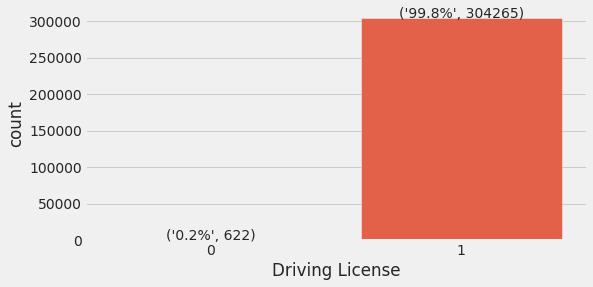

In [19]:
plt.figure(figsize=(8,4))
a=sns.countplot(x = "Driving_License", data = df2)
without_hue(df2, 'Vehicle_Age', a)
plt.xlabel("Driving License")

The countplot shows that the number of people with no Driving License is really small, with a 6.2%. Hence, we decide to delete the row of customer without any Driving license, assuming that all of the customers who buy insurance vehicle must have a driving license.

In [20]:
def removeDrivingLicense(df):
  df = df[df['Driving_License'] == 1]
  df = df.drop('Driving_License', axis = 1)
  return df

In [21]:
df3 = removeDrivingLicense(df2)

In [22]:
df3.shape

(304265, 9)

# 4. Encode Categorical Data

First, we will do ordinal encoding to the Vehicle_Age feature, as the category is related to each other with a hierarchy

In [23]:
def OrdinalEncode(df):
  #Vehicle_Age feature
  df.loc[df['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0
  df.loc[df['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
  df.loc[df['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2

  #Vehicle_Damage feature
  df.loc[df['Vehicle_Damage'] == 'Yes', 'Vehicle_Damage'] = 1
  df.loc[df['Vehicle_Damage'] == 'No', 'Vehicle_Damage'] = 0

  return df

In [24]:
df4 = OrdinalEncode(df3)

In [25]:
def EncodeCategoricalData(df, col_list):
  OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
  OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[col_list]))

  #Replace index
  OH_cols.index = df.index

  #Drop categorical column from numerical dataframe
  num_X_train = df.drop(col_list, axis=1)

  #combine back dataframe
  df_last = pd.concat([num_X_train, OH_cols], axis=1)
  return df_last


In [26]:
col_list = ['Gender']
df5 = EncodeCategoricalData(df4, col_list)

In [27]:
df5.head()

,id,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,0,1
0,138389,47,0,1,1,33823.0,172,0,0.0,1.0
1,149691,45,0,1,1,2630.0,17,0,0.0,1.0
2,213565,23,1,0,0,34669.0,126,0,0.0,1.0
3,278877,23,1,0,0,29887.0,67,0,0.0,1.0
4,181394,39,0,1,1,35636.0,16,0,1.0,0.0


# 5. Remove Outlier in Annual_Premium

In [28]:
def makeBoxplot(df, columnName):
  sns.catplot(x = "Response", y = columnName, data = df, kind ="box")

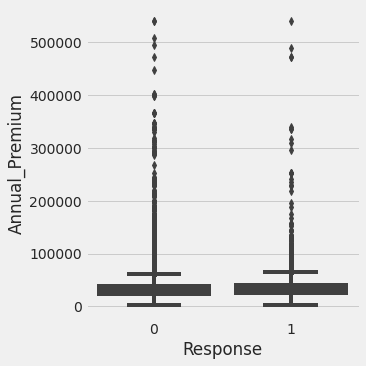

In [29]:
makeBoxplot(df5, 'Annual_Premium')

We can see that there is an outlier from our data. Hence, we decided to remove the outlier using the IQR method

In [30]:
def removeAnnualOutlier(df):
    Q1=df['Annual_Premium'].quantile(0.25)
    Q3=df['Annual_Premium'].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df['Annual_Premium']<(Q1-1.5*IQR)) | (df['Annual_Premium']>(Q3+1.5*IQR)))]
    return df_final

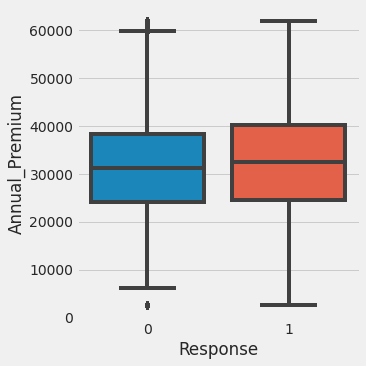

In [31]:
df6 = removeAnnualOutlier(df5)
makeBoxplot(df6, 'Annual_Premium')

# 6. Standardization

We will try to standardize our numerical data, so that it can remove any outliers. It has proven to increase our model evaluation score, where our baseline model increased 23.7% on **ROC_AUC**

In [36]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [37]:
def scaleNumericalColumn(df):
  for i in ['Age', 'Annual_Premium', 'Vintage', 'Vehicle_Age', 'Vehicle_Damage']:
    df[i] = mm.fit_transform(df[[i]])
  return df

In [38]:
df7 = scaleNumericalColumn(df6)

In [39]:
df7.head()

,id,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,0,1
0,138389,0.415385,0,0.5,1.0,0.526802,0.560554,0,0.0,1.0
1,149691,0.384615,0,0.5,1.0,0.000000,0.024221,0,0.0,1.0
2,213565,0.046154,1,0.0,0.0,0.541090,0.401384,0,0.0,1.0
3,278877,0.046154,1,0.0,0.0,0.460329,0.197232,0,0.0,1.0
4,181394,0.292308,0,0.5,1.0,0.557421,0.020761,0,1.0,0.0


# Converting the test dataset using the used function on dev dataset

In [40]:
test_file_path = 'https://raw.githubusercontent.com/darnellkikoo/AlgoBC_FProject/main/assets/test.csv'
df_test = pd.read_csv(test_file_path)

In [41]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,208442,Female,23,1,22.0,1,< 1 Year,No,48084.0,152.0,220,0
1,93685,Female,60,1,28.0,0,1-2 Year,Yes,34198.0,122.0,251,1
2,290052,Female,38,1,7.0,1,1-2 Year,No,41134.0,124.0,76,0
3,110028,Male,56,0,2.0,0,1-2 Year,Yes,32158.0,26.0,145,1
4,186246,Male,24,1,29.0,1,< 1 Year,Yes,43912.0,152.0,165,0


In [42]:
df_test1 = casting(df_test)
df_test2 = removeUnwantedFeature(df_test1)
df_test3 = removeDrivingLicense(df_test2)
df_test4 = OrdinalEncode(df_test3)
df_test5 = EncodeCategoricalData(df_test4, col_list)
df_test6 = removeAnnualOutlier(df_test5)
df_test7 = scaleNumericalColumn(df_test6)

In [43]:
df_test7.head()

,id,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,0,1
0,208442,0.046154,1,0.0,0.0,0.766160,0.726644,0,1.0,0.0
1,93685,0.615385,0,0.5,1.0,0.532102,0.833910,1,1.0,0.0
2,290052,0.276923,1,0.5,0.0,0.649013,0.228374,0,1.0,0.0
4,186246,0.061538,1,0.0,1.0,0.695838,0.536332,0,0.0,1.0
5,31148,0.184615,0,0.0,0.0,0.464139,0.311419,0,1.0,0.0


In [44]:
df7.head()

,id,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,0,1
0,138389,0.415385,0,0.5,1.0,0.526802,0.560554,0,0.0,1.0
1,149691,0.384615,0,0.5,1.0,0.000000,0.024221,0,0.0,1.0
2,213565,0.046154,1,0.0,0.0,0.541090,0.401384,0,0.0,1.0
3,278877,0.046154,1,0.0,0.0,0.460329,0.197232,0,0.0,1.0
4,181394,0.292308,0,0.5,1.0,0.557421,0.020761,0,1.0,0.0


In [45]:
from google.colab import files
df7.to_csv('dev_afterpreprocess.csv', index = False)
df_test7.to_csv('test_afterpreprocess.csv', index = False)

In [ ]:
files.download('dev_afterpreprocess.csv')
files.download('test_afterpreprocess.csv')